# Collaborative Hackathon: Classification Challenge – Bank Marketing 🏦

Welcome to **Collaborative ML Hackathon (Classification)**!

In this session, you’ll build a classification model using a real-world dataset: **Bank Marketing**.  
Your goal is to predict whether a customer will subscribe to a term deposit after a marketing campaign.

---
### Learning Objectives
- Frame a real-world classification problem.  
- Perform structured data preparation and visualisation.  
- Train, tune, and evaluate classification models.  
- Wrap the final model in a deployable API prototype.

## 1️⃣ Define the Problem

**Business context:**  
A retail bank wants to optimise its marketing calls. By predicting which customers are most likely to subscribe to a term deposit, the bank can target them more effectively and reduce wasted effort.

**Goal:**  Predict whether a client will subscribe (`yes`/`no`).

**Type of problem:**  Binary classification.

In [13]:
%pip install ucimlrepo --quiet
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo


bank_marketing = fetch_ucirepo(id=222)

X = bank_marketing.data.features
y = bank_marketing.data.targets

print(bank_marketing.metadata)
print(bank_marketing.variables)

df = pd.concat([X, y], axis=1)


{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to predict the s

## 2️⃣ Data Understanding & Initial Exploration

Let’s inspect the structure and get a sense of feature types, missing values, and target balance.

In [14]:
df.info()
df['y'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


,proportion
y,
no,0.883015
yes,0.116985


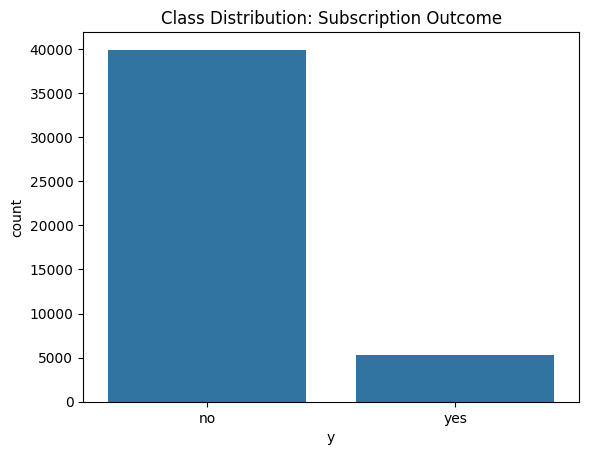

In [16]:
# Visualise class imbalance
sns.countplot(x='y', data=df)
plt.title('Class Distribution: Subscription Outcome')
plt.show()

We can see that most customers **did not** subscribe — this class imbalance is something we’ll keep in mind when evaluating models.

## 3️⃣ Data Preparation

We’ll now:
- Encode categorical features.  
- Standardise numerical values.  
- Handle class imbalance.  
- Split into train, validation, and test sets.

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

# Separate features and target
X = df.drop('y', axis=1)
y = df['y'].map({'yes': 1, 'no': 0})

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

cat_cols = X_train.select_dtypes(include=['object']).columns
num_cols = X_train.select_dtypes(exclude=['object']).columns

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

## 4️⃣ Model Selection and Training

We’ll compare two models:
- **Logistic Regression** – interpretable baseline.
- **Random Forest Classifier** – flexible non-linear model.

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Logistic Regression Pipeline
pipe_lr = Pipeline([
    ('prep', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

# Random Forest Pipeline
pipe_rf = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

# Train
pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

# Evaluate
for model, name in [(pipe_lr, 'Logistic Regression'), (pipe_rf, 'Random Forest')]:
    y_pred = model.predict(X_val)
    print(f"\n{name} Classification Report:\n", classification_report(y_val, y_pred))
    print(f"ROC-AUC: {roc_auc_score(y_val, model.predict_proba(X_val)[:,1]):.3f}")


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95      6388
           1       0.64      0.34      0.44       846

    accuracy                           0.90      7234
   macro avg       0.78      0.66      0.69      7234
weighted avg       0.89      0.90      0.89      7234

ROC-AUC: 0.910

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      6388
           1       0.69      0.39      0.50       846

    accuracy                           0.91      7234
   macro avg       0.81      0.69      0.73      7234
weighted avg       0.90      0.91      0.90      7234

ROC-AUC: 0.934


## 5️⃣ Hyperparameter Tuning

We’ll perform grid search tuning on the Random Forest model to find the best hyperparameters.

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(pipe_rf, param_grid, cv=3, scoring='roc_auc', verbose=2)
grid_search.fit(X_train, y_train)

print('Best Parameters:', grid_search.best_params_)
print(f"Best Validation ROC-AUC: {grid_search.best_score_:.3f}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END model__max_depth=10, model__min_samples_split=2, model__n_estimators=100; total time=   2.7s
[CV] END model__max_depth=10, model__min_samples_split=2, model__n_estimators=100; total time=   1.8s
[CV] END model__max_depth=10, model__min_samples_split=2, model__n_estimators=100; total time=   1.9s
[CV] END model__max_depth=10, model__min_samples_split=2, model__n_estimators=200; total time=   3.5s
[CV] END model__max_depth=10, model__min_samples_split=2, model__n_estimators=200; total time=   4.0s
[CV] END model__max_depth=10, model__min_samples_split=2, model__n_estimators=200; total time=   4.2s
[CV] END model__max_depth=10, model__min_samples_split=5, model__n_estimators=100; total time=   1.8s
[CV] END model__max_depth=10, model__min_samples_split=5, model__n_estimators=100; total time=   1.8s
[CV] END model__max_depth=10, model__min_samples_split=5, model__n_estimators=100; total time=   1.9s
[CV] END model__max_d

## 6️⃣ Model Evaluation

Evaluate the tuned model on the **test set** using ROC curve and confusion matrix.

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7985
           1       0.69      0.37      0.48      1058

    accuracy                           0.91      9043
   macro avg       0.80      0.67      0.71      9043
weighted avg       0.89      0.91      0.89      9043

Test ROC-AUC: 0.931


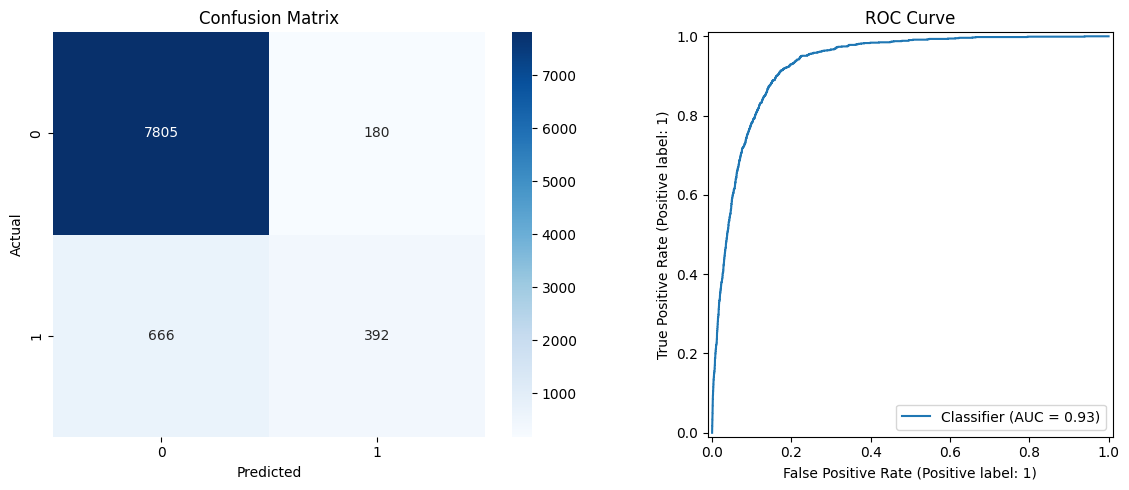

In [20]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")

# Visuals
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# ROC curve
RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[1])
axes[1].set_title('ROC Curve')

plt.tight_layout()
plt.show()

## 7️⃣ Deployment via API

We can now wrap our model into a **Flask API**. Below is a minimal example you could expand for deployment.

In [21]:
%%writefile app.py
from flask import Flask, request, jsonify
import joblib
import pandas as pd

app = Flask(__name__)
model = joblib.load('best_model.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    input_df = pd.DataFrame([data])
    prediction = model.predict(input_df)[0]
    return jsonify({'subscribed': bool(prediction)})

if __name__ == '__main__':
    app.run(debug=True)

Writing app.py


## 🧭 Summary

In this classification hackathon demo, we:
1. Defined a real-world classification problem.
2. Cleaned, encoded, and standardised data.
3. Trained and compared Logistic Regression and Random Forest models.
4. Tuned hyperparameters using Grid Search.
5. Evaluated with ROC-AUC and visual diagnostics.
6. Outlined deployment as an API service.

**Next step for you:**  Use a different dataset, follow this structure collaboratively, and design your own deployable classification prototype!